In [4]:
import numpy as np, networkx as nx, matplotlib.pyplot as plt
from pathlib import Path

In [22]:
# --- quick script: build_global_ids.py ---------------------------------
import torch, pickle, numpy as np, tqdm

ENTRIES_PT   = "/DATA/hdhanu/GNN/Subgraphs/last_quarter_subgraphs.pt"
DATA_LIST_PT = "/DATA/hdhanu/GNN/Explainability/w5_g1000_m0/cleaned_scaled.pt"          # already created
MAP_NPZ      = "/DATA/hdhanu/GNN/Explainability/w5_g1000_m0/global_id_map.npz"          # ← new file

entries   = torch.load(ENTRIES_PT,  weights_only=False)   # list of dicts
data_list = torch.load(DATA_LIST_PT, weights_only=False)  # list[Data]

assert len(data_list) == 2*len(entries)
print("Graphs:", len(data_list))

# Each element will become a 1-D numpy array of original IDs
global_id_arrays = []

for ent, data in tqdm.tqdm(zip(entries, data_list), total=len(data_list)):
    # order G.nodes() the SAME way we did in process_chunk:
    orig_ids = np.array(list(ent["subgraph"].nodes()), dtype=np.int32)
    # from_networkx() maps that order to indices in edge_index/x
    global_id_arrays.append(orig_ids) # pre-burst
    global_id_arrays.append(orig_ids) # non-burst

print("Global ID arrays:", global_id_arrays)
# save one npz bundle: key = graph index, value = array of IDs
np.savez_compressed(MAP_NPZ, *global_id_arrays)
print("saved →", MAP_NPZ)


Graphs: 5378


 50%|█████     | 2689/5378 [00:00<00:00, 83336.91it/s]

Global ID arrays: 

[array([2600, 2601, 2602, 2603, 2604, 2605, 2606, 2608, 2609, 2610, 2100,
       2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2700, 2701, 2702,
       2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2200, 2201, 2202,
       2203, 2204, 2205, 2206, 2207, 2208, 2209, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2300, 2301, 2302, 2303, 2304,
       2305, 2306, 2308, 2309, 2310, 2900, 2901, 2902, 2903, 2904, 2905,
       2906, 2908, 2400, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409,
       2410, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 3003, 3004, 3005,
       3006, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509,
       2510, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008], dtype=int32), array([2600, 2601, 2602, 2603, 2604, 2605, 2606, 2608, 2609, 2610, 2100,
       2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2700, 2701, 2702,
       2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2200, 2201, 2202,
       2203, 2204, 2205, 2206, 2207, 2208, 2209

In [5]:
run_dir   = Path("/DATA/hdhanu/GNN/Explainability/w5_g1000_m0")          # adjust
mask_file = run_dir / "gnnexp_masks/pre/graph_00000_ytensor([1]).npz"
# mask_file2 = run_dir / "gnnexp_masks/graph_00015_ytensor([0]).npz"

In [61]:
import re
import shutil

RUN_DIR  = Path("/DATA/hdhanu/GNN/Explainability/w5_g1000_m0")
MASK_DIR = RUN_DIR / "gnnexp_masks"; MASK_DIR.mkdir(exist_ok=True)

PRE_DIR, NON_DIR = MASK_DIR / "pre", MASK_DIR / "non"
PRE_DIR.mkdir(exist_ok=True); NON_DIR.mkdir(exist_ok=True)

for f in MASK_DIR.glob("graph_*_y*.npz"):
    # extract first digit after '_y'
    label_txt = f.stem.split("_y")[1]             # 'tensor([0])'
    label_int = int(re.search(r'\d+', label_txt).group())
    target    = PRE_DIR if label_int else NON_DIR
    shutil.move(f, target / f.name)
    
print(f"Moved masks to {PRE_DIR} and {NON_DIR}")
print("Done.")

Moved masks to /DATA/hdhanu/GNN/Explainability/w5_g1000_m0/gnnexp_masks/pre and /DATA/hdhanu/GNN/Explainability/w5_g1000_m0/gnnexp_masks/non
Done.


In [6]:
dat   = np.load(mask_file)
# dat2  = np.load(mask_file2)

edges: [[  0   0   0 ... 107 107 107]
 [ 30  31  50 ...  84 105 106]]   mean score: 0.5167037
nodes: 0.5604128
mask tensor([0.5037, 0.5034, 0.5034,  ..., 0.7267, 0.5080, 0.5252])


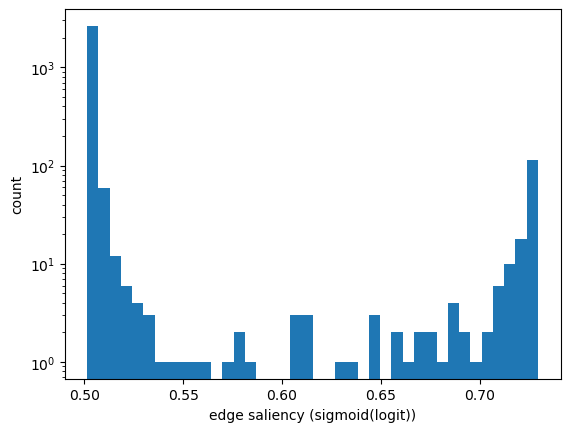

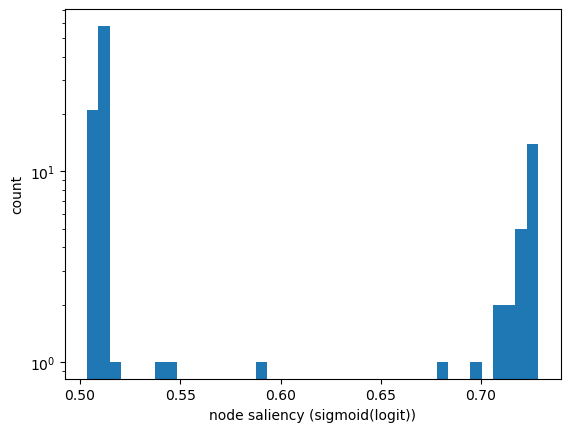

In [74]:
import torch


ei    = dat["edge_index"]           # shape (2, E)
edge_score = dat["edge_mask"]                   # saliency ∈ [0,1]
node_score = dat["node_mask"]             # saliency ∈ [0,1]
edge_mask = torch.from_numpy(dat["edge_mask"])       
node_mask = torch.from_numpy(dat["node_mask"])
# edge_mask2 = torch.from_numpy(dat2["edge_mask"])       
# node_mask2 = torch.from_numpy(dat2["node_mask"])

print("edges:", ei, "  mean score:", edge_score.mean())
print("nodes:", node_score.mean())
print("mask", edge_mask)

plt.hist(edge_mask.numpy(), bins=40, log=True)
plt.xlabel("edge saliency (sigmoid(logit))"); plt.ylabel("count")
plt.show()

plt.hist(node_mask.numpy(), bins=40, log=True)
plt.xlabel("node saliency (sigmoid(logit))"); plt.ylabel("count")
plt.show()

VISUALIZE

/tmp/ipykernel_20208/2096834308.py:40: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos,
/tmp/ipykernel_20208/2096834308.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


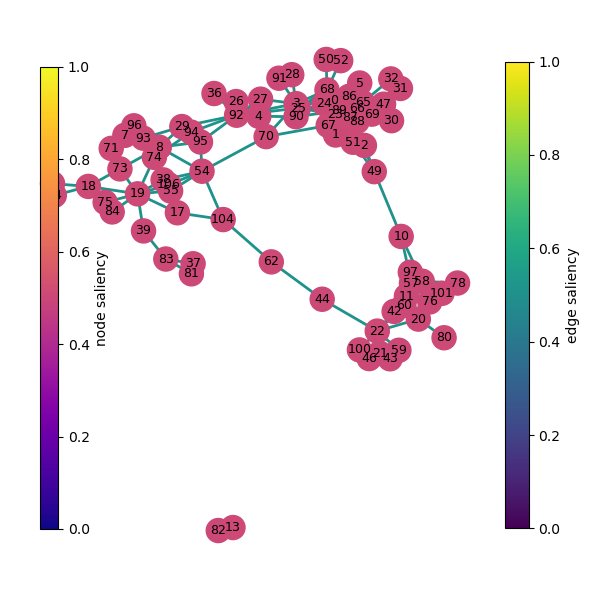

In [64]:
def plot_explanation_shifted(ei, edge_probs, node_probs, keep_top=0.02,
                             cmap_edge=plt.cm.viridis, cmap_node=plt.cm.plasma):
    """
    ei         : (2,E) edge_index (numpy or tensor)
    edge_probs : length-E tensor/array  – edge saliency (0-1)
    node_probs : length-V tensor/array  – node saliency (0-1)
    """
    edge_probs = torch.as_tensor(edge_probs, dtype=torch.float32)
    node_probs = torch.as_tensor(node_probs, dtype=torch.float32)

    k   = max(1, int(len(edge_probs) * keep_top))
    idx = edge_probs.argsort()[-k:]

    # Build subgraph from selected edges
    G = nx.Graph()
    G.add_edges_from(ei.T[idx])
    salient_nodes = sorted(G.nodes())

    # Generate node positions using spring layout
    pos = nx.spring_layout(G, seed=42, k=0.35, iterations=200)

    # Set up normalization for colour mapping
    norm_e = mpl.colors.Normalize(0, 1)
    norm_n = mpl.colors.Normalize(0, 1)

    # Determine edge colours and widths
    edge_rg = [cmap_edge(norm_e(float(v))) for v in edge_probs[idx]]
    edge_w  = [1.0 + 2.0 * float(v) for v in edge_probs[idx]]

    # Determine node colours
    node_rg = [cmap_node(norm_n(float(node_probs[i])))
               for i in salient_nodes]

    # Draw the graph
    fig, ax = plt.subplots(figsize=(6, 6))
    nx.draw_networkx_nodes(G, pos,
                           nodelist=salient_nodes,
                           node_color=node_rg,
                           node_size=300, ax=ax)
    nx.draw_networkx_edges(G, pos,
                           edge_color=edge_rg,
                           width=edge_w,
                           connectionstyle="arc3,rad=0.15",
                           ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # Edge saliency colorbar on the right
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_edge, norm=norm_e),
                 ax=ax, fraction=0.045, pad=0.01, label="edge saliency")

    # Create an axes for node saliency colorbar on the left
    pos_ax = ax.get_position()
    cax = fig.add_axes([pos_ax.x0 - 0.05, pos_ax.y0, 0.03, pos_ax.height])
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_node, norm=norm_n),
                 cax=cax, orientation='vertical', label="node saliency")

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Call the new plotting function using existing variables
plot_explanation_shifted(ei=ei,
                         edge_probs=edge_mask.cpu().numpy(),
                         node_probs=node_mask.cpu().numpy(),
                         keep_top=0.05)

PRE-BURST #14 (ABOVE N BELOW)

In [32]:
import torch, networkx as nx, matplotlib.pyplot as plt, matplotlib as mpl

EDGE_THR = 0.65          # keep edges ≥ 0.65
NODE_THR = 0.65          # optional; can set to 0.0 to skip

def plot_thresholded(ei, edge_mask, node_mask,
                     layout_seed=42, cmap_edge=plt.cm.viridis,
                     cmap_node=plt.cm.plasma):
    """
    ei        : (2,E) numpy or tensor
    edge_mask : length-E saliency in [0,1]
    node_mask : length-V saliency in [0,1]
    """

    edge_mask = torch.as_tensor(edge_mask).sigmoid()
    node_mask = torch.as_tensor(node_mask).sigmoid()

    # ---- keep only high-saliency edges ---------------------------------
    keep_e  = (edge_mask >= EDGE_THR).nonzero(as_tuple=True)[0]
    if keep_e.numel() == 0:
        print("‼  No edges ≥ threshold")
        return

    ei_keep = ei[:, keep_e]            # (2, K)
    G       = nx.Graph()
    G.add_edges_from(ei_keep.T.tolist())

    # ---- decide which nodes to draw ------------------------------------
    if NODE_THR > 0:
        keep_n = {u for e in ei_keep.T.tolist() for u in e}  # endpoints
        keep_n |= {int(i) for i,v in enumerate(node_mask) if v >= NODE_THR}
        G = G.subgraph(keep_n)

    # ---- positions & colours -------------------------------------------
    pos = nx.spring_layout(G, seed=layout_seed, k=0.40)

    norm_e  = mpl.colors.Normalize(0, 1)
    norm_n  = mpl.colors.Normalize(0, 1)

    # map only retained edges/nodes
    e_colors = [cmap_edge(norm_e(float(edge_mask[e]))) for e in keep_e]
    n_colors = [cmap_node(norm_n(float(node_mask[n]))) for n in G.nodes()]
    
    fig, ax = plt.subplots(figsize=(5, 5))
    pos_ax = ax.get_position()
    cax = fig.add_axes([pos_ax.x0 - 0.05, pos_ax.y0, 0.03, pos_ax.height])
    nx.draw_networkx_edges(G, pos, edge_color=e_colors, width=3, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=n_colors, node_size=350, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=9, ax=ax)

    # colour-bars
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_edge, norm=norm_e),
                 ax=ax, fraction=0.04, pad=0.01, label="edge saliency")
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap_node, norm=norm_n),
                 cax=cax, orientation='vertical', label="node saliency")

    ax.set_axis_off(); plt.tight_layout(); plt.show()


/tmp/ipykernel_20208/3651877601.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.set_axis_off(); plt.tight_layout(); plt.show()


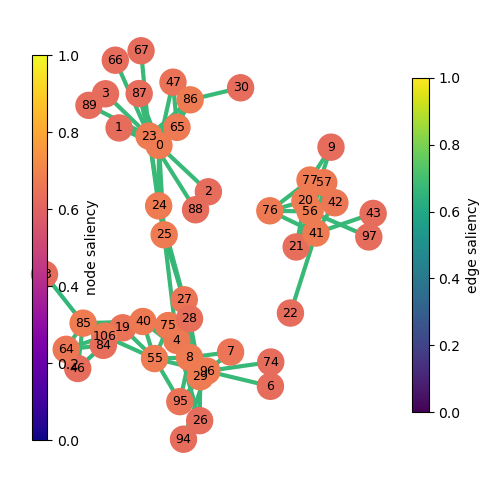

In [58]:
plot_thresholded(
    ei         = ei,
    edge_mask  = edge_mask.cpu().numpy(),          # logits or probs both okay
    node_mask  = node_mask.cpu().numpy(),          # ditto
)

/tmp/ipykernel_12191/3578296369.py:43: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(G, pos,


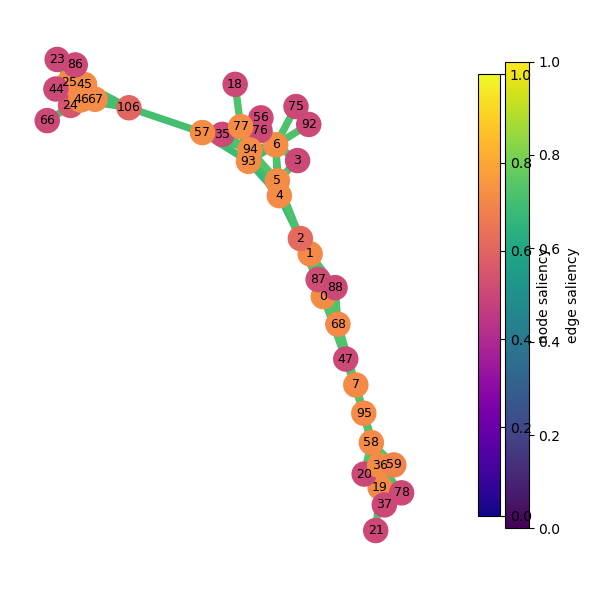

In [118]:
plot_explanation(ei=ei,
                 edge_probs=edge_mask.cpu().numpy(), node_probs=node_mask.cpu().numpy(),
                 keep_top=0.05)

In [48]:
plot_thresholded(
    ei         = ei,
    edge_mask  = edge_mask.cpu().numpy(),          # logits or probs both okay
    node_mask  = node_mask.cpu().numpy(),          # ditto
)

‼  No edges ≥ threshold


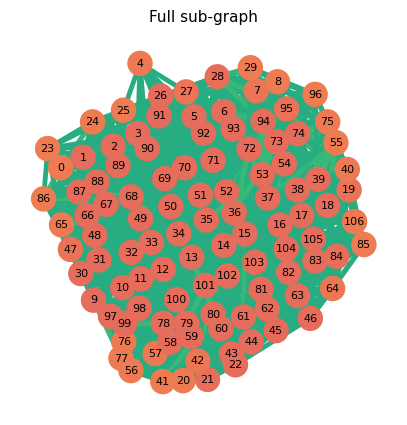

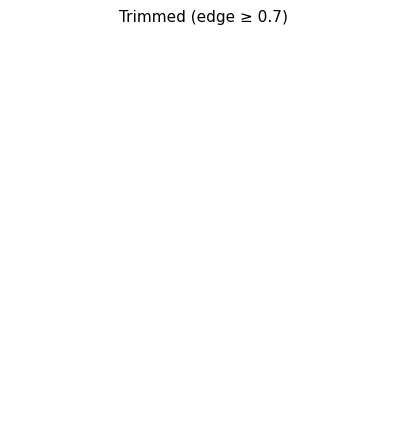

In [59]:
import torch, networkx as nx, matplotlib.pyplot as plt, matplotlib as mpl

# ──────────────────────────────────────────────────────────────────────
# 1. Core single-graph renderer
# ──────────────────────────────────────────────────────────────────────
def _draw_graph(G, pos, edge_p, node_p,
                title="", ax=None,
                cmap_e=mpl.cm.viridis, cmap_n=mpl.cm.plasma):

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    norm_e = mpl.colors.Normalize(0, 1)
    norm_n = mpl.colors.Normalize(0, 1)

    edges = list(G.edges)
    edge_col = [cmap_e(norm_e(float(edge_p[e_idx])))
                for e_idx, _ in enumerate(edges)]
    edge_w   = [1.0 + 4.0*float(edge_p[e_idx])
                for e_idx, _ in enumerate(edges)]

    node_col = [cmap_n(norm_n(float(node_p[n]))) for n in G.nodes]

    nx.draw_networkx_edges(G, pos, edge_color=edge_col, width=edge_w, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_col,
                           node_size=300, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)
    ax.set_title(title, fontsize=11)
    ax.axis("off")

    # add colour-bars only once (when no external ax supplied)
    if ax is None:
        sm_e = mpl.cm.ScalarMappable(cmap=cmap_e, norm=norm_e)
        sm_n = mpl.cm.ScalarMappable(cmap=cmap_n, norm=norm_n)
        plt.colorbar(sm_e, ax=ax, fraction=0.03, pad=0.02,
                     label="edge saliency")
        plt.colorbar(sm_n, ax=ax, fraction=0.03, pad=0.05,
                     label="node saliency")
        plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────────
# 2. Convenience wrapper to build *either* full or trimmed graph
# ──────────────────────────────────────────────────────────────────────
def build_graph(ei, edge_p, node_p, thr_edge=0.70, thr_node=0.70):
    """Return NetworkX graph filtered by the thresholds."""
    keep_e = (edge_p >= thr_edge).nonzero(as_tuple=True)[0]
    G = nx.Graph()
    G.add_edges_from(ei.T[keep_e].tolist())

    if thr_node > 0:
        keep_nodes = {u for u, v in G.edges} | {v for u, v in G.edges}
        keep_nodes |= {i for i, p in enumerate(node_p) if p >= thr_node}
        G = G.subgraph(keep_nodes)

    return G, keep_e


# ──────────────────────────────────────────────────────────────────────
# 3. Public function  ─ plots *two* separate figures
# ──────────────────────────────────────────────────────────────────────
def plot_full_then_trim(ei, edge_mask, node_mask,
                        thr_edge=0.70, thr_node=0.70,
                        seed=42):
    # tensors → probabilities
    edge_p = torch.as_tensor(edge_mask, dtype=torch.float32).sigmoid()
    node_p = torch.as_tensor(node_mask, dtype=torch.float32).sigmoid()

    # build NetworkX graphs
    G_full, _        = build_graph(ei, edge_p, node_p,   0.00, 0.00)
    G_trim, keep_idx = build_graph(ei, edge_p, node_p,
                                   thr_edge, thr_node)

    # shared layout so the two plots align visually
    pos = nx.spring_layout(G_full, seed=seed, k=0.45, iterations=200)

    # draw separately
    _draw_graph(G_full, pos, edge_p, node_p,
                title="Full sub-graph")
    _draw_graph(G_trim, pos, edge_p[keep_idx], node_p,
                title=f"Trimmed (edge ≥ {thr_edge})")


# ─────────────────────── demo ────────────────────────────
# Example call
plot_full_then_trim(
    ei        = dat["edge_index"],
    edge_mask = edge_mask,        # logits or probs
    node_mask = node_mask,
    thr_edge  = 0.70,
    thr_node  = 0.70)             # set 0 if you don't want node trim


# PLOT WITH (x,y) LOCATION

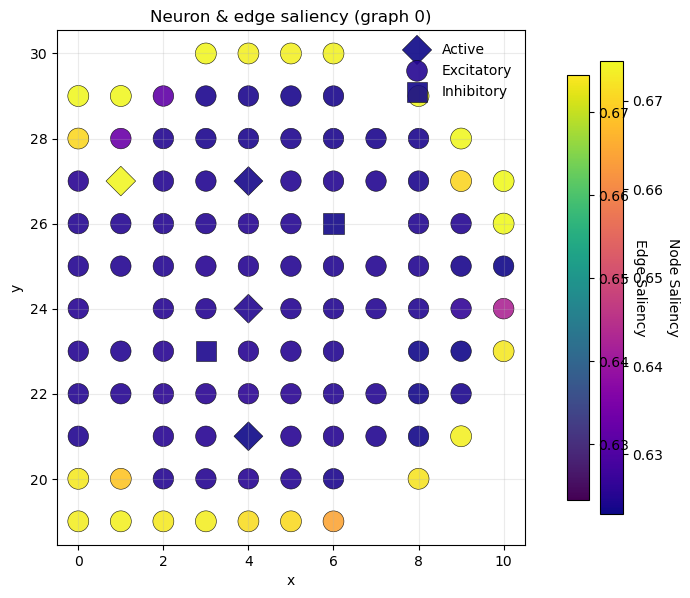

Plotted 108 nodes, 2908 / 2908 edges


In [ ]:
# ── CONFIG ─────────────────────────────────────────────────────────────
GRAPH_IDX   = 0                     # ← the sub-graph you want to show
MASK_FILE   = f"gnnexp_masks/pre/graph_00000_ytensor([1]).npz"
META_CSV    = "/DATA/hdhanu/GNN/node_attributes.csv"       # x, y, active, type
MAP_NPZ     = "/DATA/hdhanu/GNN/Explainability/w5_g1000_m0/global_id_map.npz"
ORIGIN_CSV  = "/DATA/hdhanu/GNN/burst_origin.csv"          # optional; cols x,y

EDGE_THR    = 65         # set >0 to visualise only top-saliency edges
# ────────────────────────────────────────────────────────────────────

import numpy as np, pandas as pd, torch, networkx as nx
import matplotlib.pyplot as plt, matplotlib as mpl

# 1. LOAD ALL FILES -----------------------------------------------------
map_npz  = np.load(MAP_NPZ, allow_pickle=True)
gid      = map_npz[f"arr_{GRAPH_IDX}"]          # (V,)

m        = np.load(MASK_FILE)
edge_idx = torch.tensor(m["edge_index"])        # (2,E)
edge_log = torch.tensor(m["edge_mask"]).float() # logits
node_log = torch.tensor(m["node_mask"]).float().squeeze()

edge_prob = edge_log.sigmoid().numpy()          # (E,)
node_prob = node_log.sigmoid().numpy()          # (V,)

meta = (pd.read_csv(META_CSV).rename(columns=str.strip)
          .set_index("neuronID"))

# 2. ASSERT 1-TO-1 ALIGNMENT ------------------------------------------
assert len(gid) == len(node_prob), "node_mask length mismatch"
meta_part = meta.loc[gid]                       # reorder by sub-graph order

# 3. ADD SALIENCY + PHENOTYPE -----------------------------------------
meta_part["saliency"] = node_prob
def pheno(row):
    if str(row["active"]).lower() == "true":   return "Active"
    if str(row["type"]).upper().startswith("EXC"): return "Excitatory"
    if str(row["type"]).upper().startswith("INH"): return "Inhibitory"
    return "Unknown"
meta_part["phenotype"] = meta_part.apply(pheno, axis=1)

# 4. NETWORKX GRAPH WITH EDGE PROBS ------------------------------------
G_full = nx.Graph()
G_full.add_edges_from(edge_idx.T.tolist())

# keep only edges above threshold
edges_kept = [tuple(e) for e in edge_idx.T[edge_prob >= EDGE_THR].tolist()]
G_trim = nx.Graph()
G_trim.add_edges_from(edges_kept)
G_trim = G_trim.subgraph(gid) 

# --- build positions from exactly those nodes ------------------------
pos = {nid: (meta.loc[nid, 'x'], meta.loc[nid, 'y']) for nid in G_trim.nodes}

# optional edge filter
keep_e = np.where(edge_prob >= EDGE_THR)[0]
edge_cols = edge_prob[keep_e]

# 5. PLOT ------>-------------------------------------------------------
fig, ax = plt.subplots(figsize=(7,7))

# a) edges
norm_e = mpl.colors.Normalize(node_prob.min(), node_prob.max())
edge_rgba = [mpl.cm.viridis(norm_e(p)) for p in edge_cols]
edge_width = [1.0 + 4.0*p for p in edge_cols]

nx.draw_networkx_edges(
    G_trim, pos,
    edge_color=edge_rgba, width=edge_width, ax=ax)

# b) nodes
palette = mpl.cm.plasma
# --------------------------------------------------- choose a normalisation
stretch = True          # <- flip to False if you prefer the old view
quantile = False        # <- set True for robust stretch

if stretch and not quantile:
    norm_n = mpl.colors.Normalize(node_prob.min(), node_prob.max())
elif quantile:
    qlo, qhi = np.quantile(node_prob, [0.10, 0.90])
    norm_n = mpl.colors.Normalize(qlo, qhi)
else:
    norm_n = mpl.colors.Normalize(0, 1)           # original

# node sizes can also encode saliency more aggressively
size = 80 + 420 * (node_prob - node_prob.min()) / (node_prob.max()-node_prob.min()+1e-8)
marker  = {"Excitatory":"o", "Inhibitory":"s", "Active":"D", "Unknown":"o"}

for ptype, sub in meta_part.groupby("phenotype"):
    ax.scatter(sub.x, sub.y,
               c=sub.saliency, cmap=palette, norm=norm_n,
               s=80 + 220*sub.saliency,
               marker=marker[ptype], edgecolors="k", linewidths=.4,
               label=ptype, alpha=.9)

# c) optional burst origin
try:
    origin = pd.read_csv(ORIGIN_CSV).iloc[GRAPH_IDX]    # one row per graph
    ax.scatter(origin.x, origin.y,
               s=420, marker="*", linewidths=2,
               facecolors='none', edgecolors='red',
               label="Burst origin")
except (FileNotFoundError, IndexError, KeyError):
    pass   # skip if file missing or index out of range

# 6. AESTHETICS --------------------------------------------------------
ax.set_aspect('equal','box'); ax.grid(alpha=.25)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.set_title(f"Neuron & edge saliency (graph {GRAPH_IDX})")

# legends & colour-bars
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False)

cbar_n = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_n,cmap=palette),
                      ax=ax, fraction=.04, pad=.02)
cbar_n.set_label("Node Saliency", rotation=270, labelpad=12)

cbar_e = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_e,cmap=mpl.cm.viridis),
                      ax=ax, fraction=.04, pad=.08)
cbar_e.set_label("Edge Saliency", rotation=270, labelpad=13)

plt.tight_layout(); plt.show()

# 7. INFO FOR DEBUG ----------------------------------------------------
print(f"Plotted {len(meta_part)} nodes, {len(edges_kept)} / {edge_prob.size} edges")
